# Career path

Mapping career paths at TRANSFORM 2020.

We'll use a 'vocab' so that everyone uses more or less the same words... we'll do some fuzzy matching so we don't end up with 'undergrad' and 'undergraduate' as separate things.

In [1]:
# Apart from academic, it's mostly 'where you work', not 'what you do'.
VOCAB = ["student", "undergrad", "postgrad", "postdoc", "lecturer", "professor", "reader", "academic",
         "megaservice", "service", "microservice",
         "consultant", "sales",
         "software", "technology",
         "noc", "ioc", "independent", "exploration", "e&p",
         "government", "agency", "localgov",
         "mining",
         "unemployed", "self-employed", "retired",
         "startup",
         "other", # Relevant professional but doesn't fit elsewhere
         'break'  # Non-professional career break or other gap
        ]

Some made up data, including probably 'variants' (missing numbers, misspellings, no spaces, etc.).

The format is 'job' followed by a space then a number representing the number of years there. The records are separated by commas.

In [16]:
import difflib
m = difflib.get_close_matches('govt', VOCAB, n=1, cutoff=0.8)

In [143]:
data = [
    "undergraduate 3, postgraduate 4, noc 3, software 4, consultant 1, ioc 5, microservice 10",
    "undergrd 4, independent 5, startup 5, software 3",
    "undergrad 3, service 3, postgrad 5, postdoc 3, ioc 5, professor 16, retired",
    "undergrad 3, postgrad, postdoc 3, noc 4, professor 20, retired",
    "undergrad 3, megaservice 5, software 3, unemployed 1, exploration 3, startup 1",
    "undergrad 3,postgrad 2,postgrad 4,software 3,unemployed 1,exploration 3,startup 1",
    "undergrad, postgrad, government,  mining, self-employed,"
]

## Parse data

In [144]:
import difflib
from datetime import datetime

def store_entry(data):
    """
    In the webapp, we'll record every single response 'raw' so we can process later.
    """
    with open('log.txt', 'ta') as f:
        d = datetime.utcnow().isoformat() + '\t'
        f.write(d + data + '\n')
    return 'Done'

def get_info(record):
    """
    Take a single response and turn it into a list of careers.
    
    Completely ignore the numbers for now.
    """
    items = [tuple(i.strip().split()) for i in record.split(',')]
    items = filter(None, items)
    path, years = [], {}
    for pair in items:
        # Get employment.
        m = difflib.get_close_matches(pair[0], VOCAB, n=1, cutoff=0.5)
        if m:
            path.append(m[0])
        else:
            path.append('other')

        # Get years.
        try:
            y = float(pair[1])
        except ValueError:  # Garbled number
            y = 1
        except IndexError:  # None provided
            y = 1
        years[m[0]] = y

    return path, years

In [145]:
# Just for the toy data.
paths, yearses = [], []
for record in data:
    store_entry(record)
    path, years = get_info(record)
    paths.append(path)
    yearses.append(years)

In [146]:

years, sum(years.values())

({'undergrad': 1,
  'postgrad': 1,
  'government': 1,
  'mining': 1,
  'self-employed': 1},
 5)

Use a Shelf:

In [147]:
import shelve

def store(path, years):
    with shelve.open('edges') as db:
        for pair in [*zip(path[:-1], path[1:])]:
            count = db.get(','.join(pair), 0)
            db[','.join(pair)] = count + 1
    with shelve.open('nodes') as db:
        db.update(years)
    return

In [148]:
for path, years in zip(paths, yearses):
    store(path, years)

## Make network

In [149]:
import networkx as nx

G = nx.Graph()

G.add_nodes_from(VOCAB)

with shelve.open('edges') as db:
    for e, w in db.items():
        u, v = e.split(',')
        G.add_edge(u, v, weight=w)

G.remove_nodes_from(list(nx.isolates(G)))

## Viz

- network diagram of paths
- ribbons of time

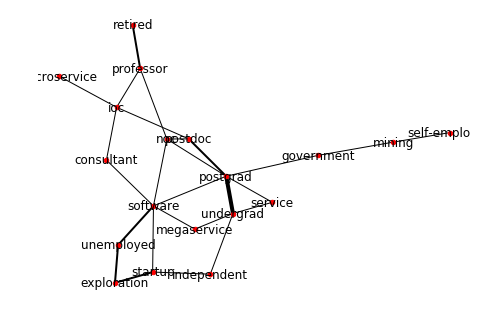

In [155]:
%matplotlib inline

edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]

params = {
    'node_size': 20,
    'with_labels': True,
    'width': weights,
}

pos = nx.spring_layout(G)

nx.draw(G, pos, **params)

## Years

In [156]:
%matplotlib inline
import matplotlib.pyplot as plt

def get_years():
    with shelve.open('nodes') as db:
        d = dict(db)

    _ = d.pop('undergrad', None)
    _ = d.pop('retired', None)
    _ = d.pop('unemployed', None)
    _ = d.pop('break', None)
    labels = list(d.keys())
    data = list(d.values())

    return data, labels

In [157]:
import numpy as np
from io import BytesIO
import base64

def plot_years(data, labels, log=False):

    data = sorted(data, reverse=True)
    labels = sorted(labels, key=lambda li: data[labels.index(li)], reverse=True)

    y = list(range(len(data)))
    y_min, y_max = y[0]-0.75, y[-1]+0.75

    fig, ax = plt.subplots(figsize=(8, 12))
    bars = ax.barh(y, data, color='orange', align='center', edgecolor='none')
    bars[np.argmax(data)].set_color('red')
    ax.set_yticks(y)
    if log:
        ax.set_xscale('log')
    ax.set_yticklabels(labels, size=12)
    ax.set_ylim(y_max, y_min)  # Label top-down.
    ax.grid(c='black', alpha=0.15, which='both')
    ax.patch.set_facecolor("white")
    fig.patch.set_facecolor("none")
    ax.set_title("{:.2f} person-careers of experience".format(sum(data)/40))

    for i, d in enumerate(data):
        ax.text(1, i, "{}".format(int(d)), va='center', size=12)

    plt.tight_layout()

    # Put in memory.
    handle = BytesIO()
    plt.savefig(handle, format='png', facecolor=fig.get_facecolor())
    plt.show()

    # Encode.
    handle.seek(0)
    figdata_png = base64.b64encode(handle.getvalue()).decode('utf8')

    return figdata_png


In [158]:
_ = plot(data, labels, log=True)

IndexError: list index out of range

# Delete the data

In [159]:
# Deletes all the data on the deployed server.
# https://careermap.softwareunderground.org/delete'